<a href="https://colab.research.google.com/github/Yeabebe/Finetuning-LLM/blob/main/finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Environment setup

In [1]:
!pip install -q evaluate
!pip install -U bitsandbytes
!pip install -U transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.4 MB/s eta 0:00:00


Imports and Configuration

In [2]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training
)
import evaluate

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
MAX_LENGTH = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


Load IMDb Dataset

In [4]:
from datasets import load_dataset

# Load IMDb dataset
dataset = load_dataset("imdb")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Convert IMDb to Instruction Format

In [5]:
def format_example(example):
    label = "Positive" if example["label"] == 1 else "Negative"

    prompt = (
        "Instruction: Classify the sentiment of the following movie review "
        "as Positive or Negative.\n\n"
        f"Review:\n{example['text']}\n\n"
        "Answer:"
    )

    return {
        "text": f"{prompt} {label}"
    }


In [6]:
train_data = dataset["train"].map(format_example, remove_columns=dataset["train"].column_names)
test_data  = dataset["test"].map(format_example, remove_columns=dataset["test"].column_names)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Tokenizer

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [8]:
def tokenize(example):
    return tokenizer(
        example["text"],
        truncation=True,
        max_length=MAX_LENGTH,
        padding="max_length"
    )


In [9]:
train_data = train_data.map(tokenize, batched=True)
test_data  = test_data.map(tokenize, batched=True)

train_data.set_format(type="torch")
test_data.set_format(type="torch")


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Baseline Model

In [10]:
baseline_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)
baseline_model.eval()


`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rot

In [11]:
def predict_sentiment(model, review):
    prompt = (
        "Instruction: Classify the sentiment of the following movie review "
        "as Positive or Negative.\n\n"
        f"Review:\n{review}\n\n"
        "Answer:"
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=5,
            do_sample=False
        )

    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return prediction.split("Answer:")[-1].strip()


In [12]:
sample = dataset["test"][0]["text"]
print(predict_sentiment(baseline_model, sample))


Negative.


QLoRA Configuration

In [13]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)


In [14]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto"
)


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

In [15]:
model = prepare_model_for_kbit_training(model)


In [16]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj", "v_proj"],
    bias="none",
    task_type="CAUSAL_LM"
)


In [17]:
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 1,126,400 || all params: 1,101,174,784 || trainable%: 0.1023


Training Setup

In [18]:
training_args = TrainingArguments(
    output_dir="./tinyllama-imdb-qlora",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=1,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    fp16=True,
    report_to="none"
)


In [19]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)


In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data.select(range(2000)),  # small eval for speed
    # tokenizer=tokenizer,
    data_collator=data_collator
)


Train

In [21]:
trainer.train()


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,2.333253,2.350456


TrainOutput(global_step=1563, training_loss=2.3539434910125636, metrics={'train_runtime': 4451.7289, 'train_samples_per_second': 5.616, 'train_steps_per_second': 0.351, 'total_flos': 3.97685293056e+16, 'train_loss': 2.3539434910125636, 'epoch': 1.0})

Save and Deploy 

In [ ]:
# Save LoRA adapters
model.save_pretrained("./tinyllama-imdb-qlora-adapter")
tokenizer.save_pretrained("./tinyllama-imdb-qlora-adapter")

# Push to Hugging Face Hub
model.push_to_hub("Yeabebe/tinyllama-imdb-qlora")
tokenizer.push_to_hub("Yeabebe/tinyllama-imdb-qlora")


Training Loss Curve

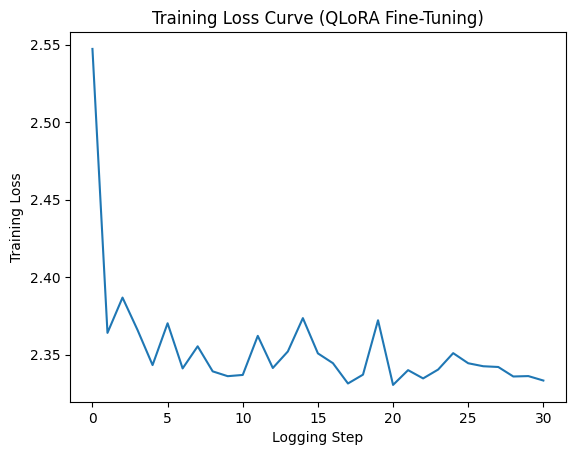

In [22]:
logs = trainer.state.log_history
losses = [log["loss"] for log in logs if "loss" in log]
steps = list(range(len(losses)))

plt.figure()
plt.plot(steps, losses)
plt.xlabel("Logging Step")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve (QLoRA Fine-Tuning)")
plt.show()


Evaluation: Baseline vs Fine-Tuned

In [23]:
accuracy = evaluate.load("accuracy")

def evaluate_model(model, dataset, n_samples=200):
    preds, labels = [], []

    for i in range(n_samples):
        raw = dataset[i]
        review = dataset[i]["text"]

        prediction = predict_sentiment(model, review)

        preds.append(1 if "Positive" in prediction else 0)
        labels.append(1 if "Positive" in raw else 0)

    return accuracy.compute(predictions=preds, references=labels)


In [24]:
baseline_acc = evaluate_model(baseline_model, test_data)
finetuned_acc = evaluate_model(model, test_data)

baseline_acc, finetuned_acc


({'accuracy': 0.235}, {'accuracy': 0.84})

Baseline vs Fine-Tuned Accuracy Bar Chart

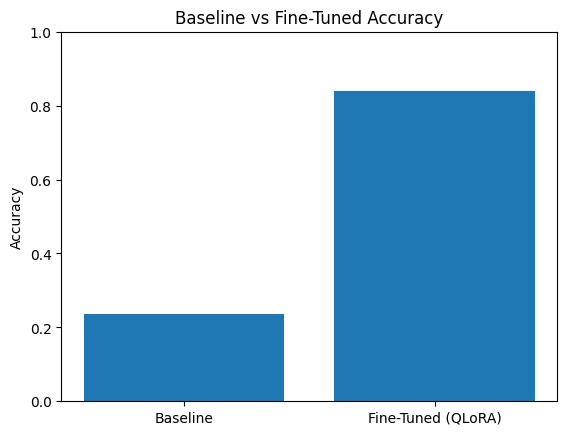

In [25]:
models = ["Baseline", "Fine-Tuned (QLoRA)"]
accuracies = [baseline_acc["accuracy"], finetuned_acc["accuracy"]]

plt.figure()
plt.bar(models, accuracies)
plt.ylabel("Accuracy")
plt.title("Baseline vs Fine-Tuned Accuracy")
plt.ylim(0, 1)
plt.show()


Example Predictions Table

In [26]:
def show_examples(model, dataset, n=5):
    for i in range(n):
        review = dataset[i]["text"][:300]
        prediction = predict_sentiment(model, review)
        print(f"Review {i+1}:")
        print("Prediction:", prediction)
        print("-" * 60)

show_examples(baseline_model, dataset["test"])
show_examples(model, dataset["test"])


Review 1:
Prediction: Positive

Re
------------------------------------------------------------
Review 2:
Prediction: Positive

Re
------------------------------------------------------------
Review 3:
Prediction: Positive

Re
------------------------------------------------------------
Review 4:
Prediction: Positive Sentiment
------------------------------------------------------------
Review 5:
Prediction: Positive

Re
------------------------------------------------------------
Review 1:
Prediction: Negative
------------------------------------------------------------
Review 2:
Prediction: Positive

Answer
------------------------------------------------------------
Review 3:
Prediction: Negative
------------------------------------------------------------
Review 4:
Prediction: Positive

Answer
------------------------------------------------------------
Review 5:
Prediction: Positive
------------------------------------------------------------


Confusion Matrix

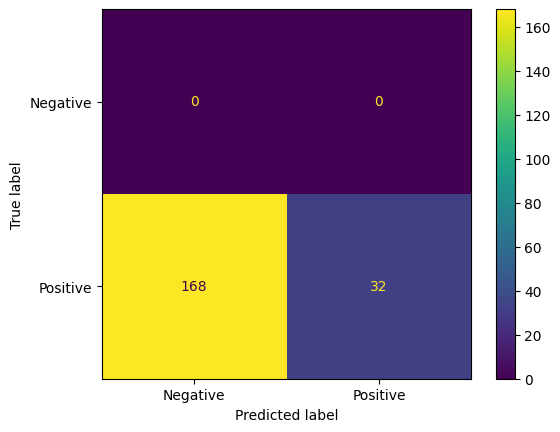

In [27]:
y_true, y_pred = [], []

for i in range(200):
    review = test_data[i]["text"]
    pred = predict_sentiment(model, review)

    y_pred.append(1 if "Positive" in pred else 0)
    y_true.append(1 if "Positive" in review else 0)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
disp.plot()
plt.show()
